## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [37]:
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from dev.abc import ABCSampler
from dev import price_rogers_2014_binned, dataprocessing, completeness
from tqdm.notebook import tqdm
from scipy.stats import gamma
from functools import partial
import warnings
# warnings.simplefilter('error', RuntimeWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# a _very_ common debugging utility
def minmeanmax(statistic, name):
    print("{0} min-mean-max-hasnan".format(name), min(statistic), np.nanmean(statistic), max(statistic), any(np.isnan(statistic)))

My ABC setup requires

- a prior occurrence estimate.
- a candidate generator for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

In [3]:
kois = dataprocessing.get_kois()
stellar = dataprocessing.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
kois = kois[np.isfinite(kois["koi_prad"])]
stellar = stellar[np.isfinite(stellar.mass)]

[190585   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

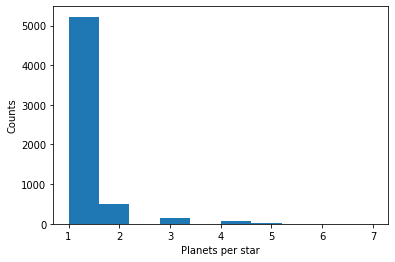

In [4]:
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
bincounts = np.bincount(solarsyssizes)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(solarsyssizes)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [5]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
koi_radii = kois["koi_prad"]
koi_periods = kois["koi_period"]

In [6]:
lam = np.mean(solarsyssizes)
# lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10) 
print([sum(planet_numbers == i) for i in range(max(planet_numbers))])

[60254, 71473, 41887, 16495, 4942, 1160, 212, 41, 3]


In [7]:
lam

1.183844477962125

(array([6.0254e+04, 7.1473e+04, 4.1887e+04, 1.6495e+04, 4.9420e+03,
        1.1600e+03, 2.1200e+02, 4.1000e+01, 3.0000e+00, 1.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

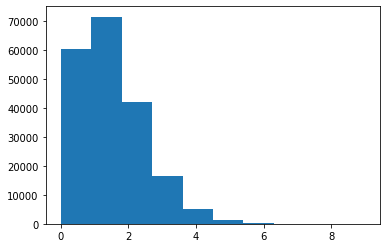

In [8]:
plt.hist(planet_numbers)

In [9]:
period = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period), np.log(rp)
log_p = np.append(log_p, np.log(640))
log_r = np.append(log_r, np.log(20))
period_rng = (min(period), max(period))
rp_rng = (min(rp), max(rp))

f = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]
# f = np.ones(shape=(len(period), len(rp)))

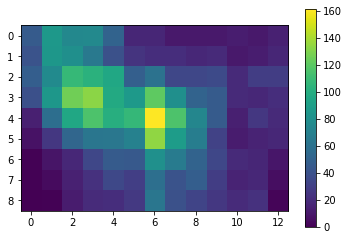

In [10]:
plt.imshow(np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0])
plt.colorbar()

In [11]:
f = lam * f / np.sum(f)

In [12]:
bucket = np.random.choice(f.size, p=f.flatten() / np.sum(f))
i, j = bucket // f.shape[1], bucket % f.shape[1] 
synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
ecc = stats.rayleigh(scale=0.03).rvs()
cosincl = np.random.uniform(-1, 1)
print("Generated planet with period {0} days, radius {1} Earth radii, eccentricity {2}, cos of orbital inclination {3}.".format(np.round(synth_p, 3), np.round(synth_r, 3), np.round(ecc, 3), np.round(cosincl, 3)))

Generated planet with period 217.496 days, radius 2.705 Earth radii, eccentricity 0.054, cos of orbital inclination 0.605.


In [13]:
cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

In [14]:
def pcomp_vectors(stars, periods, rp, eccs, cosincls):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    
    mstars = stars['mass'].values
    rstars = stars['radius'].values
    cdpp = np.array(stars[cdpp_cols], dtype=float)
    dataspan = stars['dataspan'].values
    dataspan = np.nan_to_num(dataspan)
    dutycycle = stars['dutycycle'].values
    dutycycle = np.nan_to_num(dutycycle)
    mesthres_cols_stars = np.array(stars[mesthres_cols], dtype=float)
    
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    sigma = np.nan_to_num(sigma, nan=1)
    # Compute the radius ratio and estimate the S/N.

    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    mest = np.nan_to_num(mest, nan=7.1)
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    
    M = dataspan / periods
    f = dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) & (M >= 2.0)
    pwins = pw * msk
    # pwins = np.nan_to_num(pwins)
    
    pgeom = aor * cosincls * (1 - eccs * eccs) <= 1 # for now, assume sin omega = 0
    # pgeom = 1. / (aor * (1 - eccs*eccs)) * (aor > 1.0)
    
    pgeom = np.nan_to_num(pgeom)
    
    '''try:
        assert np.all(pdets >= 0) and np.all(pdets <= 1), "pdets are out of range"
        assert np.all(pwins >= 0) and np.all(pwins <= 1), "pwins are out of range"
        assert np.all(pgeom >= 0) and np.all(pgeom <= 1), "pgeom are out of range"
    except AssertionError as e:
        for p in [pdets, pwins, pgeom]:
            minmeanmax(p, "probs in order det, win, geo")
        raise'''
    return pdets * pwins * pgeom

Text(0.5, 1.0, 'pcomps')

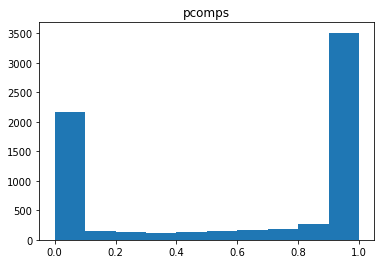

In [15]:
combined = pd.merge(kois, stellar, on='kepid')
pcomp = partial(completeness.get_completeness, pgam=pgam, mesthres_cols=mesthres_cols, mesthres_vals=mesthres_vals)
cosincls = np.cos(np.pi * combined['koi_incl'] / 180)
pcomps = pcomp_vectors(combined, combined['koi_period'], combined['koi_prad'], combined['koi_eccen'], cosincls)
plt.hist(pcomps[~np.isnan(pcomps)])
plt.title("pcomps")

In [16]:
num_stars = len(stellar)
stellar_sample = stellar.sample(n=num_stars)

(array([1256.,  938.,  714.,  559.,  452.,  451.,  433.,  371.,  345.,
         512.]),
 array([0.     , 0.09992, 0.19984, 0.29976, 0.39968, 0.4996 , 0.59952,
        0.69944, 0.79936, 0.89928, 0.9992 ]),
 <a list of 10 Patch objects>)

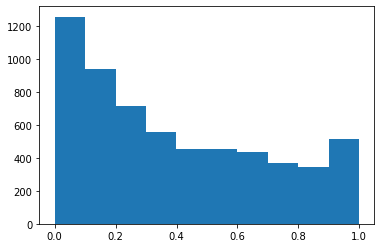

In [17]:
plt.hist(combined.koi_impact[combined.koi_impact < 1])

In [18]:
t0_range = (min(kois.koi_time0), max(kois.koi_time0))

def add_uncertainties(price_uncertainty_params):
    '''
    Adds uncertainties to parameters based on Price and Rogers (2014).
    
    Arguments
    ---------
    price_uncertainty_parameters : list of scalars / numpy.ndarrays.
    The parameters in the signature from each of the Price/Rogers variance functions.
    (delta, T, tau, f0, texp, Ttot, gamma, sigma).
    delta - transit depth
    T - full-width at half-max transit time
    tau - duration of ingress and egress
    f0 - starting flux, which we set to 1.
    texp - time of exposure, about 30 minutes for Kepler.
    Ttot -  same as P in this case, I think
    gamma - sampling rate
    sigma - model uncertainty
    
    Returns
    -------
    perturbed_parameters : list of scalars / numpy.ndarrays.
    The same list, but with white noise added.
    '''
    var_d = abs(np.vectorize(price_rogers_2014_binned.prVarDelta)(*price_uncertainty_params)) * 0 # abs is stopgap
    noise = np.random.normal(0, np.sqrt(var_d), size=(len(price_uncertainty_params[0]),))
    noise = np.nan_to_num(noise)
    price_uncertainty_params[0] += noise
    return price_uncertainty_params

def generate_planet_catalog(f, stars):
    '''
    Takes in the occurrence rate matrix f and generates `num_planets' planets, 
    represented as a matrix of state (row) vectors.
    
    Each row has: period in days; radius in Earth radii; eccentricity; cosine of inclination; impact parameter;
    time of first transit in BJD; fractional transit depth; transit duration in days; is_detected (bool).
    
    Arguments
    ---------
    f : np.ndarray
    f = f(r, p); occurrence rate prior that we sample p and r from.
    
    stars : pd.dataframe
    A sample of the stellar dataframe.
    '''
    re = 0.009171
    planet_params = ['kepid', 'period', 'prad', 'ecc', 'cosincl', 'b', 't0', 'd', 'D']
    lam = np.sum(f)
    nums_planets = np.minimum(stats.poisson(lam).rvs((len(stars),)), 10)
    num_planets = sum(nums_planets)
    stellar_catalog = pd.DataFrame(np.repeat(stars.values, nums_planets, axis=0))
    stellar_catalog.columns = stars.columns
    stellar_catalog = stellar_catalog.astype(stars.dtypes)
    flat_f = f.flatten()
    buckets = np.random.choice(f.size, p = flat_f / lam, size=(num_planets,))
    p_left_inds = buckets // f.shape[1]
    p_right_inds = p_left_inds + 1
    r_left_inds = buckets % f.shape[1]
    r_right_inds = r_left_inds + 1
    periods = np.exp(np.random.uniform(log_p[p_left_inds], log_p[p_right_inds]))
    pl_rads = np.exp(np.random.uniform(log_r[r_left_inds], log_r[r_right_inds]))
    eccens  = stats.rayleigh(scale=0.03).rvs(size=(num_planets,))
    cosincl = np.random.uniform(0, 1, size=(num_planets,))
    impacts = np.random.uniform(0, 1, size=(num_planets,))
    t0 = np.random.uniform(*t0_range, size=(num_planets,))
    ror = pl_rads * re / stellar_catalog.radius.values
    depths = ror ** 2 # these are all not nan
    aor = completeness.get_a(periods, stellar_catalog.mass.values) / stellar_catalog.radius.values
    arcsin_args = np.sqrt((1 + ror) ** 2 - impacts ** 2) / aor
    problems = np.where(arcsin_args > 1)[0]
    impacts[problems] = np.minimum(1, np.sqrt((1 + ror[problems]) ** 2 - (aor[problems]) ** 2))
    # some impacts are 1 + eps
    arcsin_args[problems] = 1
    D = (periods / np.pi) * np.arcsin(arcsin_args)
    tau0 = periods * impacts / (2 * np.pi * cosincl * np.sqrt(1 - eccens ** 2)) * 1 / (aor ** 2)
    T = 2 * tau0 * np.sqrt(1 - impacts ** 2)
    tau = 2 * tau0 * np.divide(ror, np.sqrt(1 - impacts ** 2), where = impacts != 1)
    f0 = 1
    texp = 1765.5 / 60 / 60 / 24 # s to days
    gamma = 1 / texp # inverse s to inverse days
    sigma = 1 # 'model uncertainty'
    
    price_uncertainty_params = [depths, T, tau, f0, texp, periods, gamma, sigma]
    price_uncertainty_params = add_uncertainties(price_uncertainty_params)
    
    depths = price_uncertainty_params[0]

    pl_rads = np.sqrt(depths) * stellar_catalog.radius / re
    periods = price_uncertainty_params[5]
    # [kepid, period, radius, ecc, cosincl, impact param b, t0, transit depth d, transit duration D, is_detected]
    planets_matrix = np.vstack((stellar_catalog.kepid, periods, pl_rads, eccens, cosincl, impacts, t0, depths, D)).T
    planetary_catalog = pd.DataFrame(planets_matrix, columns=planet_params)
    probs = pcomp_vectors(stellar_catalog, periods, pl_rads, eccens, cosincl)
    probs = np.array(probs)
    probs = np.nan_to_num(probs)
    if np.allclose(probs, 0):
        print("all probabilities of detection are 0")
    detected = np.random.binomial(1, np.nan_to_num(probs))
    planetary_catalog['is_detected'] = detected
    return stellar_catalog, planetary_catalog.astype({'kepid': np.int64, 'is_detected': bool})

In [19]:
st, pl = generate_planet_catalog(f, stellar_sample)
if len(stellar_sample) == len(stellar):
    pl.to_csv('../data/catalog_synth.csv')

In [20]:
sum(pl.is_detected)

12910

In [21]:
detected_planets = pl[pl.is_detected]

(array([3328., 2387., 2211., 1970., 1418.,  900.,  412.,  177.,   64.,
          43.]),
 array([-0.69304167, -0.0499065 ,  0.59322867,  1.23636383,  1.879499  ,
         2.52263417,  3.16576933,  3.8089045 ,  4.45203967,  5.09517483,
         5.73831   ]),
 <a list of 10 Patch objects>)

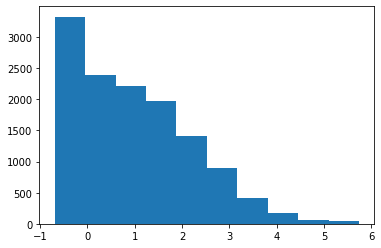

In [22]:
plt.hist(np.log(detected_planets.period))

(array([ 156., 1109., 2832., 3120., 1983., 1126.,  598.,  609.,  542.,
         835.]),
 array([-6.91872455e-01, -3.45450158e-01,  9.72139273e-04,  3.47394437e-01,
         6.93816734e-01,  1.04023903e+00,  1.38666133e+00,  1.73308363e+00,
         2.07950592e+00,  2.42592822e+00,  2.77235052e+00]),
 <a list of 10 Patch objects>)

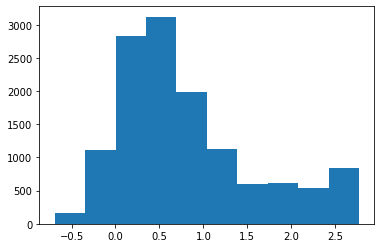

In [23]:
plt.hist(np.log(detected_planets.prad))

In [24]:
N = np.zeros_like(f)
detected = pl[pl.is_detected]
period_bins = np.digitize(np.log(detected.period), log_p)
radius_bins = np.digitize(np.log(detected.prad), log_r)
for i, j in zip(period_bins, radius_bins):
    if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
        N[i][j] += 1
        
N /= len(stellar_sample)

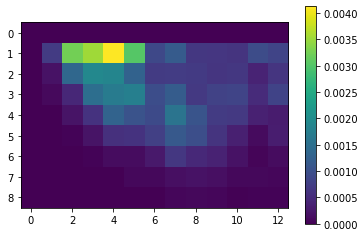

In [25]:
plt.imshow(N)
plt.colorbar()

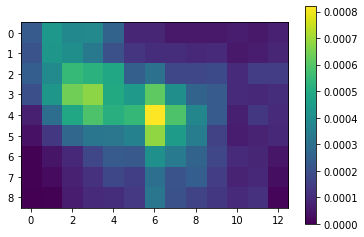

In [26]:
sample_N = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0] / len(stellar)
plt.imshow(sample_N)
plt.colorbar()

In [27]:
# %timeit generate_planet_catalog(f, stellar)
# 12.4 s ± 2.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

12.4 s ± 2.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
diff = N - sample_N
statistic = np.sum(diff ** 2)
statistic

6.649193285705629e-05

In [29]:
stellar_catalog_abc = pd.DataFrame(np.vstack([stellar[stellar.kepid == k].to_numpy() for k in kois.kepid]))
stellar_catalog_abc.columns = stellar.columns
stellar_catalog_abc = stellar_catalog_abc.astype(stellar.dtypes)

In [30]:
stellar_sample_size = len(stellar)
stellar_sample = stellar.sample(n=stellar_sample_size)

class SyntheticCatalog:
    def __init__(self, f, stars, planets=None):
        self.f = f
        if planets is None:
            self.stars, self.planets = generate_planet_catalog(f, stars)
        else:
            self.planets = planets
            self.stars = stars

class OccurrencePrior(stats.rv_continuous):
    def pdf(self, f):
        return np.prod(np.exp(-f))
    
    def rvs(self):
        return stats.expon.rvs(size=(len(period) * len(rp),))
    
def occurrence_candidate_getter(f):
    def candidate(size=1):
        return [SyntheticCatalog(f.reshape(len(period), len(rp)), stellar_sample) for _ in range(size)]
    return candidate
    
def occurrence_distance(s1, s2):
    return np.sum((s1 - s2) ** 2)

def occurrence_statistic(catalogs):
    Nstars = 0
    N = np.zeros((len(log_p) - 1, len(log_r) - 1))
    for catalog in catalogs:
        Nstars += len(catalog.stars)
        detected = catalog.planets[catalog.planets.is_detected]
        period_bins = np.digitize(np.log(detected.period.values), log_p)
        radius_bins = np.digitize(np.log(detected.prad.values), log_r)
        for i, j in zip(period_bins, radius_bins):
            if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
                N[i][j] += 1
    return N / Nstars
    
OccurrenceABCSampler = ABCSampler(OccurrencePrior(), occurrence_candidate_getter, occurrence_distance, occurrence_statistic)

In [31]:
kois_catalog_abc = kois.rename(columns={'koi_period': 'period', 'koi_prad': 'prad'})
kois_catalog_abc["is_detected"] = kois_catalog_abc["koi_disposition"] == "CONFIRMED"
kois_abc = [SyntheticCatalog(f, stellar_catalog_abc, kois_catalog_abc)]

In [32]:
abc_f = OccurrenceABCSampler.sample(kois_abc, threshold=2e-3, verbose=True)

0.0020376477794673796
0.0020219407541682546


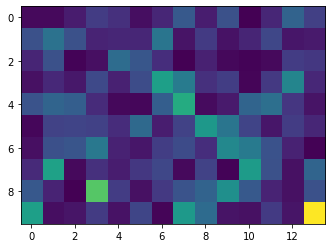

In [34]:
plt.imshow(abc_f.reshape((len(period), len(rp))))

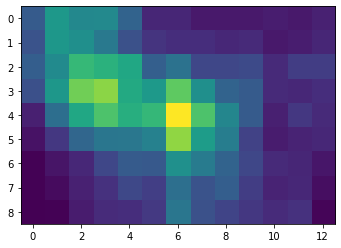

In [35]:
plt.imshow(f)

impact parameter > 1: either a FP, or on the edge of the star. The transiting object has to be big, and often that's actually a star.

In [41]:
# Do not run till this is rewritten to be vectorized
warnings.simplefilter('ignore', RuntimeWarning)
abc_pmc_f = OccurrenceABCSampler.sample_pmc(kois_abc, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 2)

[[3.21841765 0.61144194 0.3357947  0.24311823 1.48715012 0.30710734
  0.48545151 0.32104585 3.69952302 0.86445664 1.47565217 1.34967569
  0.01353032 0.10503751 1.64741844 0.41973634 0.19777889 2.23493144
  2.96377815 1.5965098  0.20869902 0.42331676 0.29427199 0.92085637
  0.40463591 0.88048812 4.82797177 0.30718476 0.77960679 1.82488101
  0.01210331 0.07570058 0.41823533 0.13646589 0.5990283  3.04845804
  0.6338349  1.26056712 0.44275445 1.54138489 1.77853167 0.39301572
  0.56761889 1.23419981 0.48148321 1.92396646 3.6736082  0.81266414
  0.07664901 0.92636654 0.37124113 0.77829719 1.15748757 0.74759337
  1.48166894 0.40880026 0.64815358 0.26524543 2.55293412 0.33741599
  1.21643555 0.51551293 0.84373419 0.3926772  0.14885486 0.34208647
  4.07252204 0.48710606 0.84609561 1.02516175 0.84281233 0.27392204
  0.93820154 0.60184901 0.28489717 0.72439755 2.34031873 0.09698211
  1.44205874 1.50589923 0.19644417 0.61841893 0.35692087 0.36370442
  0.79588171 0.59504879 3.06785633 0.01264125 0.

LinAlgError: singular matrix

In [ ]:
i = 10
p = combined['koi_period'][i]
r = combined['koi_prad'][i]
rstar = combined['radius'][i]
ror = r / rstar * 0.009158
d = ror ** 2
b = combined['koi_impact'][i]
cosincl = np.cos(combined['koi_incl'][i] * np.pi / 180)
ecc = stats.rayleigh(scale=0.03).rvs() * 0
aor = completeness.get_a(p, combined['mass'][i]) / rstar
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
D = (p / np.pi) * np.arcsin(np.sqrt((1 + p / rstar) ** 2 - b ** 2) / aor)
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
tau = 2 * tau0 * r / np.sqrt(1 - b ** 2)
f0 = 1
texp = 1765.5 / 60 / 60 / 24 # s to days
gamma = 1 / texp # inverse s to inverse days
sigma = 1 # 'model uncertainty'
price_uncertainty_params = [d, T, tau, f0, texp, p, gamma, sigma]
print(price_rogers_2014_binned.prVarDelta(*price_uncertainty_params))